<a href="https://colab.research.google.com/github/shin0105/4YP/blob/master/tinygp_practice_plots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#installing packages
!pip install jaxopt
!pip install tinygp

In [ ]:
#importing packages
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import jaxopt
import tinygp
jax.config.update("jax_enable_x64", True)

from statsmodels.datasets import co2

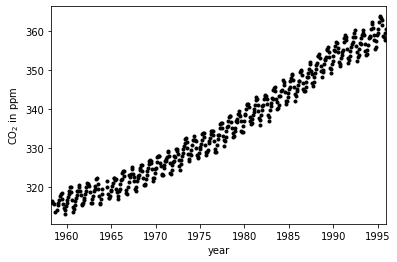

In [ ]:
#example from https://github.com/dfm/tinygp/blob/main/docs/tutorials/quickstart.ipynb

data = co2.load_pandas().data
t = 2000 + (np.array(data.index.to_julian_date()) - 2451545.0) / 365.25
y = np.array(data.co2)
m = np.isfinite(t) & np.isfinite(y) & (t < 1996)
t, y = t[m][::4], y[m][::4]

plt.plot(t, y, ".k")
plt.xlim(t.min(), t.max())
plt.xlabel("year")
_ = plt.ylabel("CO$_2$ in ppm")

In [ ]:
def build_gp(theta, X):

    # We want most of our parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    amps = jnp.exp(theta["log_amps"])
    scales = jnp.exp(theta["log_scales"])

    # Construct the kernel by multiplying and adding `Kernel` objects
    k1 = amps[0] * kernels.ExpSquared(scales[0])
    k2 = (
        amps[1]
        * kernels.ExpSquared(scales[1])
        * kernels.ExpSineSquared(
            scale=jnp.exp(theta["log_period"]),
            gamma=jnp.exp(theta["log_gamma"]),
        )
    )
    k3 = amps[2] * kernels.RationalQuadratic(
        alpha=jnp.exp(theta["log_alpha"]), scale=scales[2]
    )
    k4 = amps[3] * kernels.ExpSquared(scales[3])
    kernel = k1 + k2 + k3 + k4

    return GaussianProcess(
        kernel, X, diag=jnp.exp(theta["log_diag"]), mean=theta["mean"]
    )


def neg_log_likelihood(theta, X, y):
    gp = build_gp(theta, X)
    return -gp.log_probability(y)


theta_init = {
    "mean": np.float64(340.0),
    "log_diag": np.log(0.19),
    "log_amps": np.log([66.0, 2.4, 0.66, 0.18]),
    "log_scales": np.log([67.0, 90.0, 0.78, 1.6]),
    "log_period": np.float64(0.0),
    "log_gamma": np.log(4.3),
    "log_alpha": np.log(1.2),
}

# `jax` can be used to differentiate functions, and also note that we're calling
# `jax.jit` for the best performance.
obj = jax.jit(jax.value_and_grad(neg_log_likelihood))

print(f"Initial negative log likelihood: {obj(theta_init, t, y)[0]}")
print(
    f"Gradient of the negative log likelihood, wrt the parameters:\n{obj(theta_init, t, y)[1]}"
)

Initial negative log likelihood: 392.9423118570042
Gradient of the negative log likelihood, wrt the parameters:
{'log_alpha': DeviceArray(3.3025811, dtype=float64), 'log_amps': DeviceArray([-56.37950097,   1.71669126,   4.11084749,  -2.13098285], dtype=float64), 'log_diag': DeviceArray(60.28268107, dtype=float64), 'log_gamma': DeviceArray(12.52278878, dtype=float64), 'log_period': DeviceArray(2339.70173768, dtype=float64), 'log_scales': DeviceArray([117.65693454,  -3.10865356, -27.13290445,  -4.04980878], dtype=float64), 'mean': DeviceArray(-0.15787706, dtype=float64)}


In [ ]:
solver = jaxopt.ScipyMinimize(fun=neg_log_likelihood)
soln = solver.run(theta_init, X=t, y=y)
print(f"Final negative log likelihood: {soln.state.fun_val}")

Final negative log likelihood: 296.59832192988256


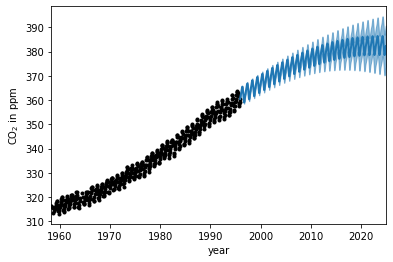

In [ ]:
x = np.linspace(max(t), 2025, 2000)
gp = build_gp(soln.params, t)
cond_gp = gp.condition(y, x).gp
mu, var = cond_gp.loc, cond_gp.variance

plt.plot(t, y, ".k")
plt.fill_between(
    x, mu + np.sqrt(var), mu - np.sqrt(var), color="C0", alpha=0.5
)
plt.plot(x, mu, color="C0", lw=2)

plt.xlim(t.min(), 2025)
plt.xlabel("year")
_ = plt.ylabel("CO$_2$ in ppm")

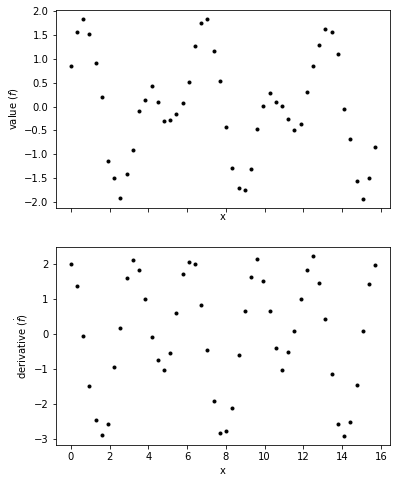

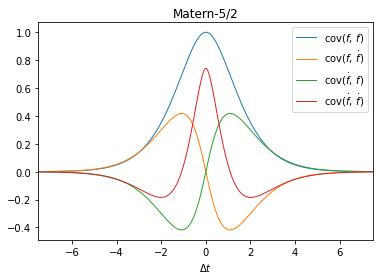

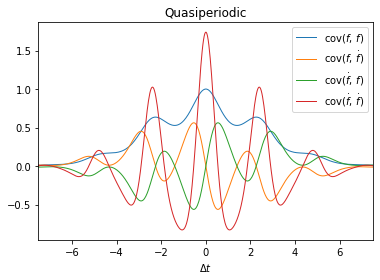

In [ ]:
#example from https://tinygp.readthedocs.io/en/latest/tutorials/derivative.html

X = np.linspace(0.0, 5 * np.pi, 50)
y = np.concatenate(
    (
        np.sin(2 * X) + np.cos(X),
        -np.sin(X) + 2 * np.cos(2 * X),
    )
)
flag = np.concatenate(
    (np.zeros(len(X), dtype=bool), np.ones(len(X), dtype=bool))
)
X = np.concatenate((X, X))
y += 0.1 * np.random.default_rng(1234).normal(size=len(y))

fig, axes = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
axes[0].plot(X[~flag], y[~flag], ".k", label="value")
axes[1].plot(X[flag], y[flag], ".k", label="derivative")
axes[0].set_xlabel("x")
axes[1].set_xlabel("x")
axes[0].set_ylabel("value ($f$)")
_ = axes[1].set_ylabel(r"derivative ($\dot{f}$)")

class DerivativeKernel(tinygp.kernels.Kernel):
    def __init__(self, kernel):
        self.kernel = kernel

    def evaluate(self, X1, X2):
        t1, d1 = X1
        t2, d2 = X2

        # Differentiate the kernel function: the first derivative wrt x1
        Kp = jax.grad(self.kernel.evaluate, argnums=0)

        # ... and the second derivative
        Kpp = jax.grad(Kp, argnums=1)

        # Evaluate the kernel matrix and all of its relevant derivatives
        K = self.kernel.evaluate(t1, t2)
        d2K_dx1dx2 = Kpp(t1, t2)

        # For stationary kernels, these are related just by a minus sign, but we'll
        # evaluate them both separately for generality's sake
        dK_dx2 = jax.grad(self.kernel.evaluate, argnums=1)(t1, t2)
        dK_dx1 = Kp(t1, t2)

        return jnp.where(
            d1, jnp.where(d2, d2K_dx1dx2, dK_dx1), jnp.where(d2, dK_dx2, K)
        )

def plot_kernel(base_kernel):
    kernel = DerivativeKernel(base_kernel)

    N = 500
    dt = np.linspace(-7.5, 7.5, N)

    k00 = kernel(
        (jnp.zeros((1)), jnp.zeros((1), dtype=bool)),
        (dt, np.zeros(N, dtype=bool)),
    )[0]
    k11 = kernel(
        (jnp.zeros((1)), jnp.ones((1), dtype=bool)),
        (dt, np.ones(N, dtype=bool)),
    )[0]
    k01 = kernel(
        (jnp.zeros((1)), jnp.zeros((1), dtype=bool)),
        (dt, np.ones(N, dtype=bool)),
    )[0]
    k10 = kernel(
        (jnp.zeros((1)), jnp.ones((1), dtype=bool)),
        (dt, np.zeros(N, dtype=bool)),
    )[0]

    plt.figure()
    plt.plot(dt, k00, label="$\mathrm{cov}(f,\,f)$", lw=1)
    plt.plot(dt, k01, label="$\mathrm{cov}(f,\,\dot{f})$", lw=1)
    plt.plot(dt, k10, label="$\mathrm{cov}(\dot{f},\,f)$", lw=1)
    plt.plot(dt, k11, label="$\mathrm{cov}(\dot{f},\,\dot{f})$", lw=1)
    plt.legend()
    plt.xlabel(r"$\Delta t$")
    plt.xlim(dt.min(), dt.max())


plot_kernel(tinygp.kernels.Matern52(scale=1.5))
plt.title("Matern-5/2")

plot_kernel(
    tinygp.kernels.ExpSquared(scale=2.5)
    * tinygp.kernels.ExpSineSquared(scale=2.5, gamma=0.5)
)
_ = plt.title("Quasiperiodic")



Initial negative log likelihood: 98.40600089321082
Final negative log likelihood: -13.27256035026602


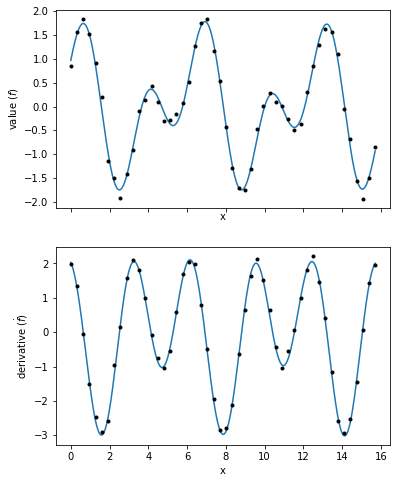

In [ ]:
def build_gp(params):
    base_kernel = jnp.exp(2 * params["log_amp"]) * tinygp.kernels.ExpSquared(
        scale=jnp.exp(params["log_scale"])
    )
    kernel = DerivativeKernel(base_kernel)

    # Note that we're passing in (X, flag) as the input coordinates.
    return tinygp.GaussianProcess(
        kernel, (X, flag), diag=jnp.exp(params["log_diag"])
    )


@jax.jit
def loss(params):
    gp = build_gp(params)
    return -gp.log_probability(y)


init = {
    "log_scale": np.log(1.5),
    "log_amp": np.log(1.0),
    "log_diag": np.log(0.1),
}
print(f"Initial negative log likelihood: {loss(init)}")
solver = jaxopt.ScipyMinimize(fun=loss)
soln = solver.run(init)
print(f"Final negative log likelihood: {soln.state.fun_val}")

X_grid = np.linspace(0, 5 * np.pi, 500)
gp = build_gp(soln.params)

# Predict the function values for the function and its derivative
mu1 = gp.condition(y, (X_grid, np.zeros(len(X_grid), dtype=bool))).gp.loc
mu2 = gp.condition(y, (X_grid, np.ones(len(X_grid), dtype=bool))).gp.loc

fig, axes = plt.subplots(2, 1, figsize=(6, 8), sharex=True)

axes[0].plot(X_grid, mu1)
axes[0].plot(X[~flag], y[~flag], ".k")
axes[1].plot(X_grid, mu2)
axes[1].plot(X[flag], y[flag], ".k", label="derivative")

axes[0].set_xlabel("x")
axes[1].set_xlabel("x")
axes[0].set_ylabel("value ($f$)")
_ = axes[1].set_ylabel(r"derivative ($\dot{f}$)")

Maximum likelihood parameters:
{'log_amp': DeviceArray(0.1, dtype=float64), 'log_scale': DeviceArray([0., 0.], dtype=float64)}


ValueError: ignored

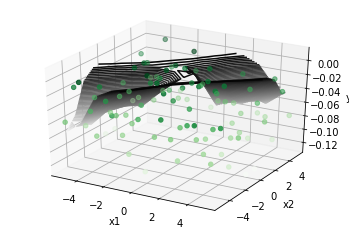

In [49]:
#plotting for simple function as practice
#drop-wave function

X = np.linspace((-5.12,-5.12),(5.12,5.12),10)
yerr = 0.01
y = -(1+np.cos(12*np.sqrt(X[:, 0]**2+X[:, 1]**2)))/(0.5*(X[:, 0]**2+X[:, 1]**2)+2) + yerr * np.random.normal(
    size=len(X))
X1,X2 = np.meshgrid(X[:,0], X[:,1])
y_true = -(1+np.cos(12*np.sqrt(X1**2+X2**2)))/(0.5*(X1**2+X2**2)+2)
obs = -(1+np.cos(12*np.sqrt(X1**2+X2**2)))/(0.5*(X1**2+X2**2)+2) + + yerr * np.random.normal(
    size=len(X))
X_pred = np.vstack((X1.flatten(), X2.flatten())).T

params = {
        "log_amp": np.float64(0.1),
        "log_scale": np.zeros(2),
    }

kernel = jnp.exp(params["log_amp"]) * tinygp.transforms.Linear(
        jnp.exp(-params["log_scale"]), tinygp.kernels.Matern52()
    )
gp = tinygp.GaussianProcess(kernel, X, diag=yerr**2)

@jax.jit
def loss(params):
    return gp.log_probability(y)

solver = jaxopt.ScipyMinimize(fun=loss)
soln = solver.run(params)
print("Maximum likelihood parameters:")
print(soln.params)

y_pred = gp.condition(y, X_pred).gp.loc.reshape(y_true.shape)

#finding mean and variance
gp_cond = gp.condition(y, X_pred).gp
mu, var = gp_cond.loc, gp_cond.variance

from mpl_toolkits import mplot3d
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(X1, X2, obs, c=obs, cmap='Greens')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('y');

ax.contour3D(X1, X2, y_pred, 50, cmap='binary')
ax.fill_between(
    X1,X2,
    mu + np.sqrt(var),
    mu - np.sqrt(var),
    color="C0",
    alpha=0.5,
    label="conditional",
)